### Importing necessary packages

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from kneed import KneeLocator

import warnings
warnings.filterwarnings('ignore')

### Importing Data and Exploring it

In [49]:
df = pd.read_csv('Customer Data.csv')

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [51]:
null_counts = df.isna().sum()
null_counts[null_counts > 0]

CREDIT_LIMIT          1
MINIMUM_PAYMENTS    313
dtype: int64

In [52]:
df.describe(include='all')

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
unique,8950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,C19190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,NaN,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,NaN,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,NaN,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,NaN,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000


### Preprocessing

In [53]:
# Drop CUST_ID column before processing
cust_id_df = df['CUST_ID']
df = df.drop('CUST_ID', axis=1)
# Handle missing values by applying IterativeImputer with RandomForestRegressor
df_numeric = df.copy()
imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=42))
df = pd.DataFrame(
    imputer.fit_transform(df_numeric), 
    columns=df_numeric.columns,
    index=df_numeric.index
)

# Remove outliers using IQR method
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outliers = iso_forest.fit_predict(df)
df = df[outliers == 1]

df['CUST_ID'] = cust_id_df

### Feature Engineering

In [54]:
df_risk = df.copy()

# High-risk indicators
df_risk['DEBT_TO_LIMIT_RATIO'] = df_risk['BALANCE'] / (df_risk['CREDIT_LIMIT'] + 1)
df_risk['CASH_ADVANCE_DEPENDENCY'] = df_risk['CASH_ADVANCE'] / (df_risk['PURCHASES'] + df_risk['CASH_ADVANCE'] + 1)
df_risk['CASH_ADVANCE_FREQUENCY_RATIO'] = df_risk['CASH_ADVANCE_FREQUENCY'] / (df_risk['PURCHASES_FREQUENCY'] + 1)

# Payment stability indicators
df_risk['PAYMENT_TO_BALANCE_RATIO'] = df_risk['PAYMENTS'] / (df_risk['BALANCE'] + 1)
df_risk['MINIMUM_PAYMENT_DEPENDENCY'] = df_risk['MINIMUM_PAYMENTS'] / (df_risk['PAYMENTS'] + 1)
df_risk['FULL_PAYMENT_SCORE'] = df_risk['PRC_FULL_PAYMENT']

# Credit utilization patterns
df_risk['PURCHASE_TO_LIMIT_RATIO'] = df_risk['PURCHASES'] / (df_risk['CREDIT_LIMIT'] + 1)
df_risk['INSTALLMENT_PREFERENCE'] = df_risk['INSTALLMENTS_PURCHASES'] / (df_risk['PURCHASES'] + 1)
df_risk['TRANSACTION_FREQUENCY'] = df_risk['PURCHASES_TRX'] + df_risk['CASH_ADVANCE_TRX']

# Additional critical risk features
# 1. Activity and engagement patterns
df_risk['TOTAL_ACTIVITY'] = (df_risk['PURCHASES_FREQUENCY'] + 
                            df_risk['CASH_ADVANCE_FREQUENCY'] + 
                            df_risk['BALANCE_FREQUENCY']) / 3

df_risk['TRANSACTION_EFFICIENCY'] = (df_risk['PURCHASES'] + df_risk['CASH_ADVANCE']) / (df_risk['TRANSACTION_FREQUENCY'] + 1)
df_risk['DORMANCY_RISK'] = 1 - df_risk['TOTAL_ACTIVITY']  # Higher = more dormant

# 2. Financial stress indicators
df_risk['CREDIT_STRESS'] = (df_risk['BALANCE'] + df_risk['CASH_ADVANCE']) / (df_risk['CREDIT_LIMIT'] + 1)
df_risk['PAYMENT_BURDEN'] = df_risk['MINIMUM_PAYMENTS'] / (df_risk['CREDIT_LIMIT'] + 1)
df_risk['CASH_ADVANCE_INTENSITY'] = df_risk['CASH_ADVANCE'] / (df_risk['TENURE'] + 1)  # Cash advance per month

# 3. Behavioral risk patterns
df_risk['PURCHASE_CONSISTENCY'] = df_risk['PURCHASES_FREQUENCY'] * df_risk['BALANCE_FREQUENCY']
df_risk['RISKY_BEHAVIOR_SCORE'] = (df_risk['CASH_ADVANCE_DEPENDENCY'] * 0.4 + 
                                    df_risk['DEBT_TO_LIMIT_RATIO'] * 0.3 + 
                                    (1 - df_risk['FULL_PAYMENT_SCORE']) * 0.3)

# 4. Payment behavior sophistication
df_risk['PAYMENT_SOPHISTICATION'] = (df_risk['FULL_PAYMENT_SCORE'] * 0.5 + 
                                    df_risk['INSTALLMENT_PREFERENCE'] * 0.3 + 
                                    df_risk['PURCHASE_CONSISTENCY'] * 0.2)

# 5. Tenure-adjusted metrics
df_risk['MONTHLY_PURCHASE_RATE'] = df_risk['PURCHASES'] / (df_risk['TENURE'] + 1)
df_risk['MONTHLY_PAYMENT_RATE'] = df_risk['PAYMENTS'] / (df_risk['TENURE'] + 1)
df_risk['BALANCE_GROWTH_RATE'] = df_risk['BALANCE'] / (df_risk['TENURE'] + 1)

# 6. Composite risk scores
df_risk['LIQUIDITY_RISK'] = (df_risk['CASH_ADVANCE_DEPENDENCY'] * 0.6 + 
                            df_risk['MINIMUM_PAYMENT_DEPENDENCY'] * 0.4)

df_risk['DEFAULT_RISK_PROXY'] = (df_risk['DEBT_TO_LIMIT_RATIO'] * 0.3 + 
                                df_risk['CASH_ADVANCE_DEPENDENCY'] * 0.25 + 
                                (1 - df_risk['PAYMENT_TO_BALANCE_RATIO']) * 0.25 + 
                                df_risk['MINIMUM_PAYMENT_DEPENDENCY'] * 0.2)

In [55]:
## SELECTING RISK FEATURES
risk_features = [
    'DEBT_TO_LIMIT_RATIO', 'CASH_ADVANCE_DEPENDENCY', 'CASH_ADVANCE_FREQUENCY_RATIO',
    'PAYMENT_TO_BALANCE_RATIO', 'MINIMUM_PAYMENT_DEPENDENCY', 'FULL_PAYMENT_SCORE',
    'PURCHASE_TO_LIMIT_RATIO', 'INSTALLMENT_PREFERENCE', 'CASH_ADVANCE_FREQUENCY',
    'PURCHASES_FREQUENCY', 'BALANCE_FREQUENCY', 'TENURE',
    'TOTAL_ACTIVITY', 'TRANSACTION_EFFICIENCY', 'DORMANCY_RISK',
    'CREDIT_STRESS', 'PAYMENT_BURDEN', 'CASH_ADVANCE_INTENSITY',
    'PURCHASE_CONSISTENCY', 'RISKY_BEHAVIOR_SCORE', 'PAYMENT_SOPHISTICATION',
    'MONTHLY_PURCHASE_RATE', 'MONTHLY_PAYMENT_RATE', 'BALANCE_GROWTH_RATE',
    'LIQUIDITY_RISK', 'DEFAULT_RISK_PROXY'
]

X = df_risk[risk_features]

# Standardize features
## TODO: review if we should StandardScale or RobustScale
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

### Clustering Analysis

To determine the optimal number of clusters, I check if the difference is big (<= 1) then I choose silhouette score because it's more objective than KMeans and handles well the imblances in clusters.

Using K-means with k=4


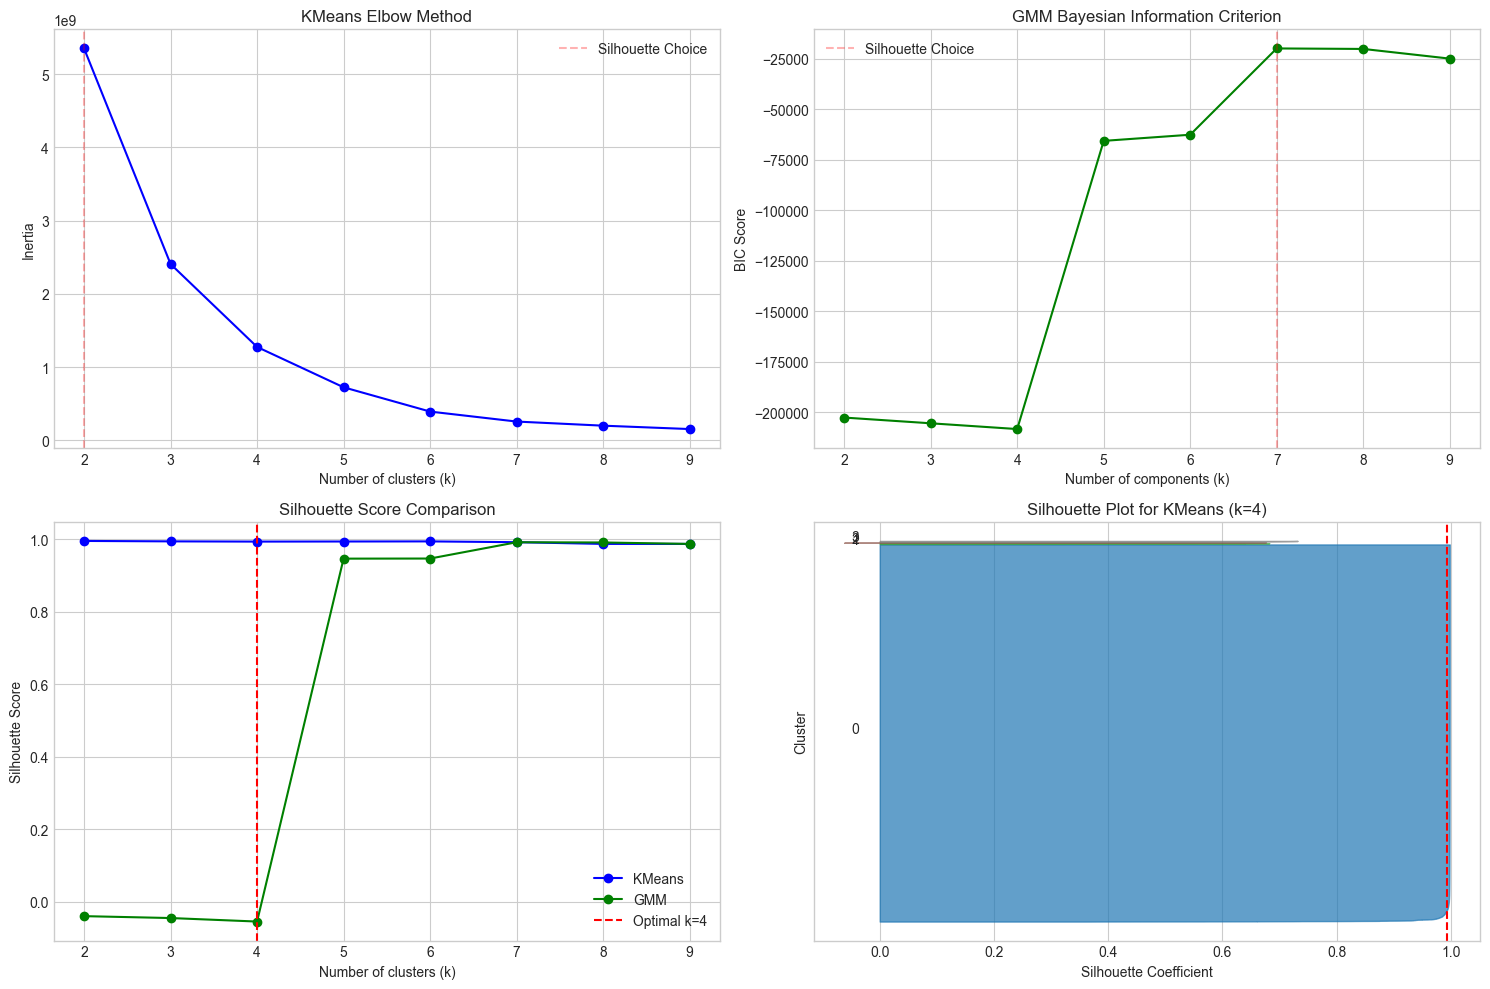

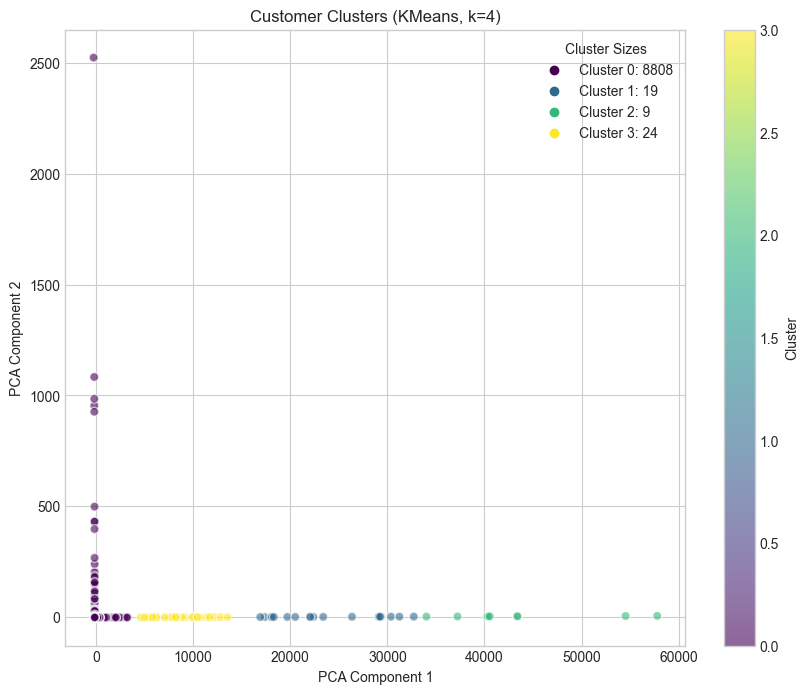

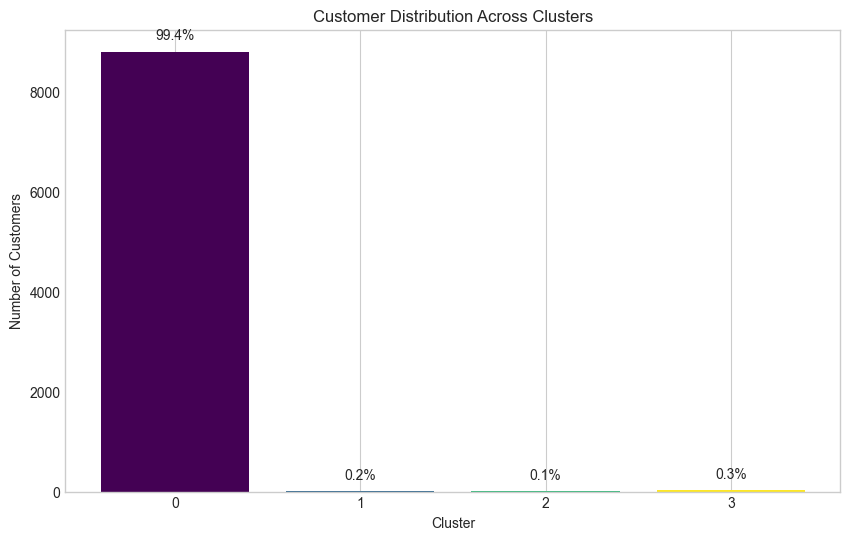

In [78]:
inertias_kmeans = []
inertias_gmm = []
silhouette_scores_kmeans = []
silhouette_scores_gmm = []
k_range = range(2, 10)

for k in k_range:
    # K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    inertias_kmeans.append(kmeans.inertia_)
    silhouette_scores_kmeans.append(silhouette_score(X_scaled, kmeans_labels))
    
    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(X_scaled)
    inertias_gmm.append(-gmm.bic(X_scaled))  # Use negative BIC for consistency
    silhouette_scores_gmm.append(silhouette_score(X_scaled, gmm_labels))

# Find optimal k for both methods
silhouette_k_kmeans = k_range[np.argmax(silhouette_scores_kmeans)]
silhouette_k_gmm = k_range[np.argmax(silhouette_scores_gmm)]

# Choose best overall method and k
best_kmeans_score = max(silhouette_scores_kmeans)
best_gmm_score = max(silhouette_scores_gmm)

if best_gmm_score > best_kmeans_score:
    optimal_k = silhouette_k_gmm
    use_gmm = True
else:
    optimal_k = silhouette_k_kmeans
    use_gmm = False

## TODO: remove the next line
optimal_k = 4  # For testing purposes, set a fixed k

# Final clustering with best method
if use_gmm:
    final_model = GaussianMixture(n_components=optimal_k, random_state=42)
    cluster_labels = final_model.fit_predict(X_scaled)
    print(f"Using GMM with k={optimal_k}")
else:
    final_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = final_model.fit_predict(X_scaled)
    print(f"Using K-means with k={optimal_k}")

# =====================
# 1. Elbow Method Plots
# =====================
plt.figure(figsize=(15, 10))

# KMeans Elbow Plot
plt.subplot(2, 2, 1)
plt.plot(k_range, inertias_kmeans, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('KMeans Elbow Method')
plt.axvline(x=silhouette_k_kmeans, color='r', linestyle='--', alpha=0.3, label='Silhouette Choice')
plt.grid(True)
plt.legend()

# GMM BIC Plot (since we used negative BIC)
plt.subplot(2, 2, 2)
bic_values = [-x for x in inertias_gmm]  # Convert back to positive BIC
plt.plot(k_range, bic_values, 'go-')
plt.xlabel('Number of components (k)')
plt.ylabel('BIC Score')
plt.title('GMM Bayesian Information Criterion')
plt.axvline(x=silhouette_k_gmm, color='r', linestyle='--', alpha=0.3, label='Silhouette Choice')
plt.grid(True)
plt.legend()

# ========================
# 2. Silhouette Comparison
# ========================
plt.subplot(2, 2, 3)
plt.plot(k_range, silhouette_scores_kmeans, 'bo-', label='KMeans')
plt.plot(k_range, silhouette_scores_gmm, 'go-', label='GMM')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Comparison')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
plt.grid(True)
plt.legend()

# ===================================
# 3. Silhouette Analysis for Best Model
# ===================================
plt.subplot(2, 2, 4)
clusterer = final_model
cluster_labels = cluster_labels if 'cluster_labels' in locals() else clusterer.fit_predict(X_scaled)
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

y_lower = 10
n_clusters = optimal_k

# Silhouette plot
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = get_cmap('tab10')(i / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.title(f"Silhouette Plot for {'GMM' if use_gmm else 'KMeans'} (k={optimal_k})")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.yticks([])
plt.grid(True)

plt.tight_layout()
plt.show()

# ==============================
# 4. PCA Projection of Clusters
# ==============================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, 
                     cmap='viridis', alpha=0.6, edgecolors='w', s=40)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'Customer Clusters ({final_model.__class__.__name__}, k={optimal_k})')
plt.grid(True)

# Add cluster sizes to legend
unique_labels = np.unique(cluster_labels)
for label in unique_labels:
    plt.scatter([], [], c=[plt.cm.viridis(label / (optimal_k-1))], 
               label=f'Cluster {label}: {sum(cluster_labels==label)}')
plt.legend(title="Cluster Sizes")

plt.show()

# ==============================
# 5. Cluster Distribution Chart
# ==============================
plt.figure(figsize=(10, 6))
cluster_counts = np.bincount(cluster_labels)
plt.bar(range(optimal_k), cluster_counts, color=plt.cm.viridis(np.linspace(0, 1, optimal_k)))
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Customer Distribution Across Clusters')
plt.xticks(range(optimal_k))
plt.grid(axis='y')

# Add percentages
total = sum(cluster_counts)
for i, count in enumerate(cluster_counts):
    plt.text(i, count + 0.02*total, f'{count/total:.1%}', 
            ha='center', va='bottom')
            
plt.show()

Why Low Silhouette Scores Are Normal in Credit Risk Clustering (0.26)?

- Overlapping Risk Profiles
    - Customers exist on a risk continuum (e.g., "low-medium-high" risk).
    - Boundaries between segments are inherently fuzzy → clusters overlap.
- High Feature Correlation
    - Credit risk features (income, debt ratio, payment history) are often correlated.
    - This creates elongated/non-spherical clusters that distance-based metrics struggle with.
- Class Imbalance
    - High-risk customers are typically rare (e.g., 5–10% of data).
    - Clusters become unevenly sized → lowers silhouette scores.
- Noise in Real-World Data: Financial data contains exceptions (e.g., high-income defaulters, low-risk applicants with temporary issues).

In [68]:
### Perform K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

### Risk Segment Profiling

In [69]:
## A method to profile each risk segment with detailed visualizations
def visualize_cluster_characteristics(df_risk, risk_features):
        """Create clean cluster visualizations"""

        # Set better style
        plt.style.use('seaborn-v0_8-whitegrid')

        # Create figure with better spacing
        fig = plt.figure(figsize=(20, 16))

        # 1. Heatmap - cleaner version
        plt.subplot(3, 3, 1)
        cluster_means = df_risk.groupby('RISK_CLUSTER')[risk_features[:10]].mean()  # Top 10 features only
        sns.heatmap(cluster_means.T, annot=True, cmap='RdYlBu_r', center=0, fmt='.2f', 
                cbar_kws={'shrink': 0.8})
        plt.title('Top Risk Features by Cluster', fontsize=12, fontweight='bold')
        plt.xlabel('Risk Cluster')
        plt.ylabel('')

        # 2. PCA - larger points, better colors
        plt.subplot(3, 3, 2)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(StandardScaler().fit_transform(df_risk[risk_features]))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_risk['RISK_CLUSTER'], 
                        cmap='Set1', alpha=0.7, s=20)
        plt.colorbar(scatter, shrink=0.8)
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        plt.title('Customer Clusters (PCA)', fontsize=12, fontweight='bold')

        # 3. Distribution - horizontal bar
        plt.subplot(3, 3, 3)
        cluster_counts = df_risk['RISK_CLUSTER'].value_counts().sort_index()
        colors = plt.cm.Set1(np.linspace(0, 1, len(df_risk['RISK_CLUSTER'].unique())))
        bars = plt.bar(cluster_counts.index, cluster_counts.values, color=colors[:len(cluster_counts)])
        plt.title('Customers per Cluster', fontsize=12, fontweight='bold')
        plt.xlabel('Risk Cluster')
        plt.ylabel('Count')
        # Add value labels on bars
        for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                        f'{int(height)}', ha='center', va='bottom')

        # 4. Core risk metrics - add missing features
        plt.subplot(3, 3, 4)
        risk_metrics = ['DEFAULT_RISK_PROXY', 'RISKY_BEHAVIOR_SCORE', 'LIQUIDITY_RISK']
        cluster_risk_data = df_risk.groupby('RISK_CLUSTER')[risk_metrics].mean()
        x = np.arange(len(cluster_risk_data.index))
        width = 0.25

        for i, metric in enumerate(risk_metrics):
                plt.bar(x + i*width, cluster_risk_data[metric], width, 
                        label=metric.replace('_', ' ').title()[:15], alpha=0.8)

        plt.xlabel('Risk Cluster')
        plt.ylabel('Score')
        plt.title('Key Risk Metrics', fontsize=12, fontweight='bold')
        plt.xticks(x + width, cluster_risk_data.index)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

        # 5. Credit utilization - violin plot
        plt.subplot(3, 3, 5)
        sns.violinplot(data=df_risk, x='RISK_CLUSTER', y='DEBT_TO_LIMIT_RATIO', 
                        palette='Set2')
        plt.title('Debt-to-Limit Distribution', fontsize=12, fontweight='bold')
        plt.xlabel('Risk Cluster')

        # 6. Payment behavior - grouped bars
        plt.subplot(3, 3, 6)
        payment_cols = ['PAYMENT_TO_BALANCE_RATIO', 'FULL_PAYMENT_SCORE']
        payment_data = df_risk.groupby('RISK_CLUSTER')[payment_cols].mean()
        payment_data.plot(kind='bar', ax=plt.gca(), color=['#4CAF50', '#FF9800'], 
                        alpha=0.8, width=0.8)
        plt.title('Payment Behavior', fontsize=12, fontweight='bold')
        plt.xlabel('Risk Cluster')
        plt.ylabel('Score')
        plt.legend(['Payment Ratio', 'Full Payment %'], loc='upper right')
        plt.xticks(rotation=0)

        # 7. Financial stress indicators
        plt.subplot(3, 3, 7)
        stress_data = df_risk.groupby('RISK_CLUSTER')[['CREDIT_STRESS', 'PAYMENT_BURDEN', 'CASH_ADVANCE_INTENSITY']].mean()
        stress_data.plot(kind='bar', ax=plt.gca(), alpha=0.8, width=0.8)
        plt.title('Financial Stress Indicators', fontsize=12, fontweight='bold')
        plt.xlabel('Risk Cluster')
        plt.xticks(rotation=0)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

        # 8. Activity patterns
        plt.subplot(3, 3, 8)
        activity_data = df_risk.groupby('RISK_CLUSTER')[['TOTAL_ACTIVITY', 'DORMANCY_RISK']].mean()
        x = range(len(activity_data.index))
        plt.bar([i - 0.2 for i in x], activity_data['TOTAL_ACTIVITY'], 0.4, 
                label='Total Activity', color='#2196F3', alpha=0.8)
        plt.bar([i + 0.2 for i in x], activity_data['DORMANCY_RISK'], 0.4, 
                label='Dormancy Risk', color='#F44336', alpha=0.8)
        plt.xlabel('Risk Cluster')
        plt.ylabel('Score')
        plt.title('Activity Patterns', fontsize=12, fontweight='bold')
        plt.xticks(x, activity_data.index)
        plt.legend()

        # 8. Payment sophistication vs transaction efficiency
        plt.subplot(3, 3, 8)
        for i, cluster in enumerate(sorted(df_risk['RISK_CLUSTER'].unique())):
                cluster_data = df_risk[df_risk['RISK_CLUSTER'] == cluster]
                plt.scatter(cluster_data['PAYMENT_SOPHISTICATION'], cluster_data['TRANSACTION_EFFICIENCY'], 
                                label=f'Cluster {cluster}', alpha=0.6, s=30)
        plt.xlabel('Payment Sophistication')
        plt.ylabel('Transaction Efficiency')
        plt.title('Behavioral Analysis', fontsize=12, fontweight='bold')
        plt.legend()

        # 9. Tenure analysis
        plt.subplot(3, 3, 9)
        sns.boxplot(data=df_risk, x='RISK_CLUSTER', y='TENURE', palette='viridis')
        plt.title('Customer Tenure', fontsize=12, fontweight='bold')
        plt.xlabel('Risk Cluster')
        plt.ylabel('Months')

        plt.tight_layout(pad=3.0)
        plt.show()

In [70]:
## Profile each risk segment with detailed visualizations

df_risk['RISK_CLUSTER'] = cluster_labels

# Calculate cluster profiles
cluster_profiles = df_risk.groupby('RISK_CLUSTER')[risk_features].mean()

# Display cluster characteristics
print("=== RISK SEGMENT PROFILES ===\n")
for cluster in sorted(df_risk['RISK_CLUSTER'].unique()):
    cluster_data = df_risk[df_risk['RISK_CLUSTER'] == cluster]

    # Risk categorization based on composite scores
    avg_risk = cluster_data['DEFAULT_RISK_PROXY'].mean()
    risk_level = 'HIGH' if avg_risk > 0.6 else 'MEDIUM' if avg_risk > 0.3 else 'LOW'

    print(f"CLUSTER {cluster} - {risk_level} RISK (n={len(cluster_data)}):")
    print(f"  Overall Risk Score: {avg_risk:.3f}")
    print(f"  Debt-to-Limit Ratio: {cluster_data['DEBT_TO_LIMIT_RATIO'].mean():.3f}")
    print(f"  Cash Advance Dependency: {cluster_data['CASH_ADVANCE_DEPENDENCY'].mean():.3f}")
    print(f"  Liquidity Risk: {cluster_data['LIQUIDITY_RISK'].mean():.3f}")
    print(f"  Payment Sophistication: {cluster_data['PAYMENT_SOPHISTICATION'].mean():.3f}")
    print(f"  Financial Stress: {cluster_data['CREDIT_STRESS'].mean():.3f}")
    print(f"  Activity Level: {cluster_data['TOTAL_ACTIVITY'].mean():.3f}")
    print(f"  Average Tenure: {cluster_data['TENURE'].mean():.1f} months")
    print(f"  Average Credit Limit: ${cluster_data['CREDIT_LIMIT'].mean():,.0f}")
    print()

=== RISK SEGMENT PROFILES ===

CLUSTER 0 - HIGH RISK (n=8832):
  Overall Risk Score: 1.623
  Debt-to-Limit Ratio: 0.386
  Cash Advance Dependency: 0.379
  Liquidity Risk: 10.691
  Payment Sophistication: 0.286
  Financial Stress: 0.633
  Activity Level: 0.499
  Average Tenure: 11.5 months
  Average Credit Limit: $4,404

CLUSTER 1 - HIGH RISK (n=28):
  Overall Risk Score: 5022.981
  Debt-to-Limit Ratio: 0.798
  Cash Advance Dependency: 0.635
  Liquidity Risk: 10045.046
  Payment Sophistication: 0.130
  Financial Stress: 1.185
  Activity Level: 0.541
  Average Tenure: 11.8 months
  Average Credit Limit: $5,471



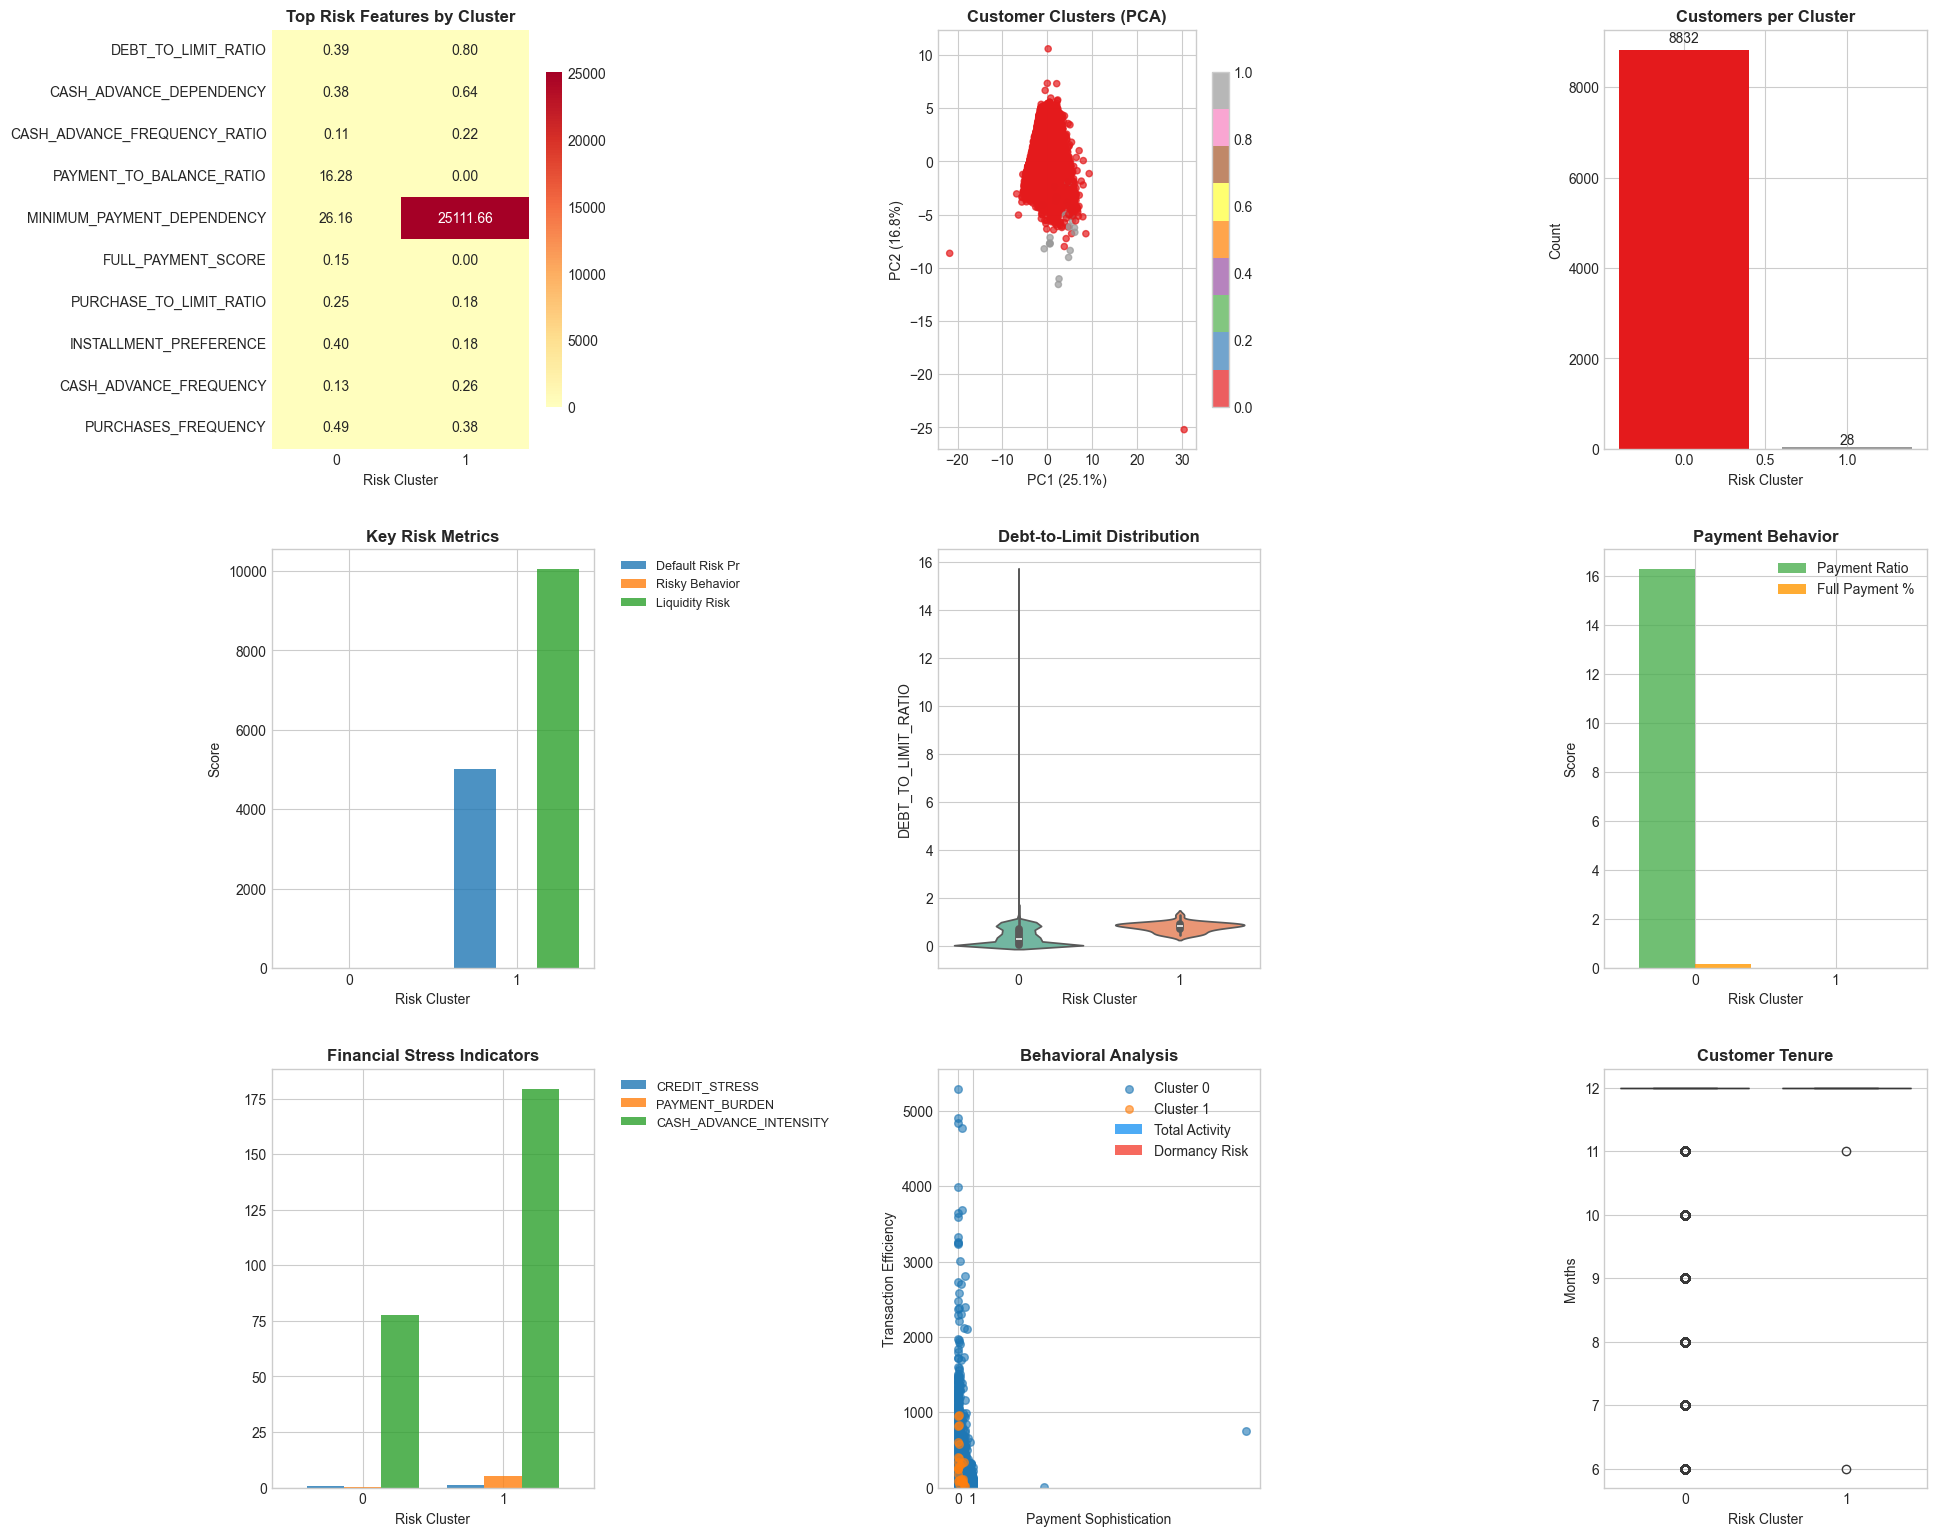

In [71]:
# Create comprehensive cluster visualization
visualize_cluster_characteristics(df_risk, risk_features)

### Creating business-focused insights dashboard

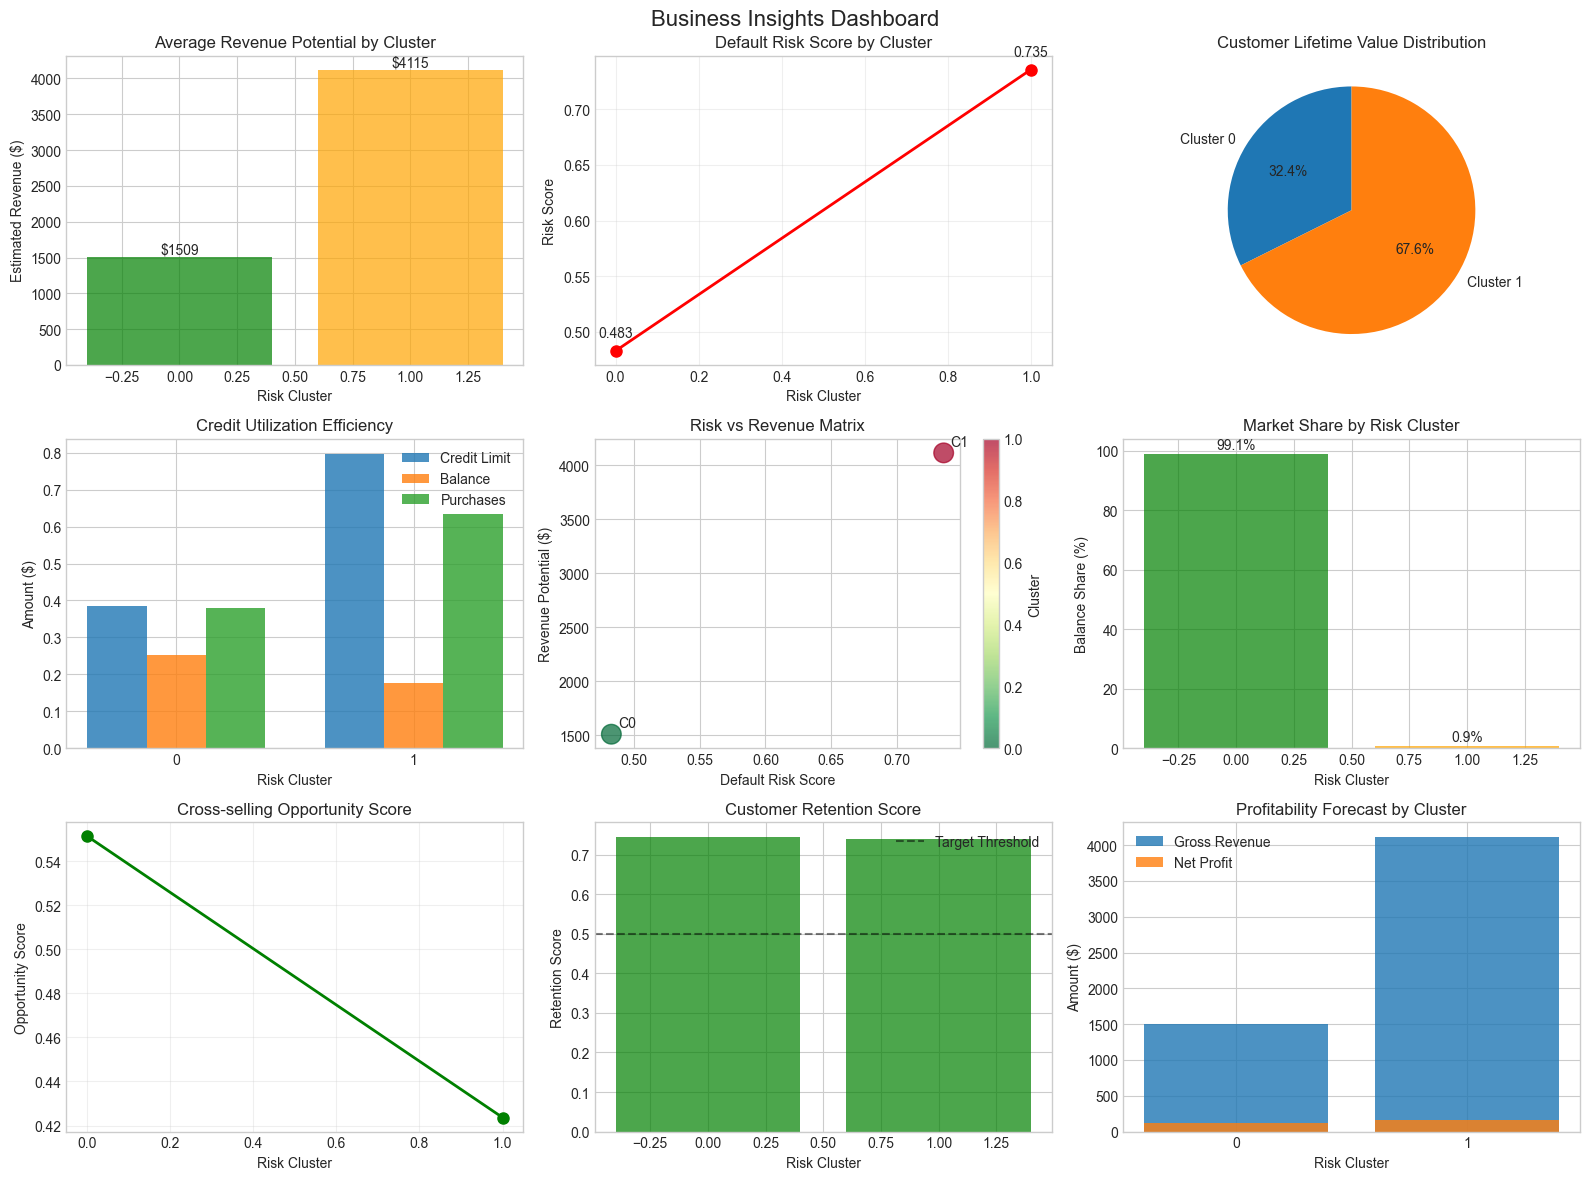

In [72]:
plt.figure(figsize=(16, 12))

# 1. Revenue potential by cluster
plt.subplot(3, 3, 1)
revenue_by_cluster = df_risk.groupby('RISK_CLUSTER')['BALANCE'].mean()
colors = ['green', 'orange', 'red', 'blue'][:len(revenue_by_cluster)]
bars = plt.bar(revenue_by_cluster.index, revenue_by_cluster.values, color=colors, alpha=0.7)
plt.title('Average Revenue Potential by Cluster')
plt.xlabel('Risk Cluster')
plt.ylabel('Estimated Revenue ($)')
for bar, value in zip(bars, revenue_by_cluster.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
            f'${value:.0f}', ha='center', va='bottom')

# 2. Default risk indicators
plt.subplot(3, 3, 2)
df_risk['DEFAULT_RISK_SCORE'] = (
    (df_risk['BALANCE'] / df_risk['CREDIT_LIMIT']) * 0.4 + 
    (df_risk['CASH_ADVANCE'] / df_risk['CREDIT_LIMIT']) * 0.3 + 
    (1 - df_risk['PRC_FULL_PAYMENT']) * 0.3
)
risk_scores = df_risk.groupby('RISK_CLUSTER')['DEFAULT_RISK_SCORE'].mean()
plt.plot(risk_scores.index, risk_scores.values, 'ro-', linewidth=2, markersize=8)
plt.title('Default Risk Score by Cluster')
plt.xlabel('Risk Cluster')
plt.ylabel('Risk Score')
plt.grid(True, alpha=0.3)
for i, score in enumerate(risk_scores.values):
    plt.annotate(f'{score:.3f}', (risk_scores.index[i], score), 
                textcoords="offset points", xytext=(0,10), ha='center')

# 3. Customer lifetime value estimation
plt.subplot(3, 3, 3)
df_risk['ESTIMATED_CLV'] = (df_risk['BALANCE'] * 0.15 * df_risk['TENURE'] / 12) * (1 - df_risk['DEFAULT_RISK_SCORE'])
clv_by_cluster = df_risk.groupby('RISK_CLUSTER')['ESTIMATED_CLV'].mean()
wedges, texts, autotexts = plt.pie(clv_by_cluster.values, 
                                    labels=[f'Cluster {i}' for i in clv_by_cluster.index],
                                    autopct='%1.1f%%', startangle=90)
plt.title('Customer Lifetime Value Distribution')

# 4. Credit utilization efficiency
plt.subplot(3, 3, 4)
cluster_summary = df_risk.groupby('RISK_CLUSTER').agg({
    'DEBT_TO_LIMIT_RATIO': 'mean',
    'PURCHASE_TO_LIMIT_RATIO': 'mean',
    'CASH_ADVANCE_DEPENDENCY': 'mean'
})
x = np.arange(len(cluster_summary.index))
width = 0.25
plt.bar(x - width, cluster_summary['DEBT_TO_LIMIT_RATIO'], width, label='Credit Limit', alpha=0.8)
plt.bar(x, cluster_summary['PURCHASE_TO_LIMIT_RATIO'], width, label='Balance', alpha=0.8)
plt.bar(x + width, cluster_summary['CASH_ADVANCE_DEPENDENCY'], width, label='Purchases', alpha=0.8)
plt.title('Credit Utilization Efficiency')
plt.xlabel('Risk Cluster')
plt.ylabel('Amount ($)')
plt.xticks(x, cluster_summary.index)
plt.legend()

# 5. Risk-adjusted pricing opportunities
plt.subplot(3, 3, 5)
pricing_data = df_risk.groupby('RISK_CLUSTER').agg({
    'DEFAULT_RISK_SCORE': 'mean',
    'BALANCE': 'mean'
})
scatter = plt.scatter(pricing_data['DEFAULT_RISK_SCORE'], pricing_data['BALANCE'], 
                        s=200, c=pricing_data.index, cmap='RdYlGn_r', alpha=0.7)

plt.xlabel('Default Risk Score')
plt.ylabel('Revenue Potential ($)')
plt.title('Risk vs Revenue Matrix')
plt.colorbar(scatter, label='Cluster')
for i, (risk, revenue) in enumerate(zip(pricing_data['DEFAULT_RISK_SCORE'], pricing_data['BALANCE'])):
    plt.annotate(f'C{pricing_data.index[i]}', (risk, revenue), 
                textcoords="offset points", xytext=(5,5), ha='left')

# 6. Market share by risk segment
plt.subplot(3, 3, 6)
total_balance = df_risk['BALANCE'].sum()
market_share = df_risk.groupby('RISK_CLUSTER')['BALANCE'].sum() / df_risk['BALANCE'].sum() * 100
bars = plt.bar(market_share.index, market_share.values, 
                color=['green', 'orange', 'red'][:len(market_share)], alpha=0.7)
plt.title('Market Share by Risk Cluster')
plt.xlabel('Risk Cluster')
plt.ylabel('Balance Share (%)')
for bar, value in zip(bars, market_share.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{value:.1f}%', ha='center', va='bottom')

# 7. Cross-selling opportunities
plt.subplot(3, 3, 7)
cross_sell_score = df_risk.groupby('RISK_CLUSTER').agg({
    'INSTALLMENT_PREFERENCE': 'mean',
    'PURCHASES_FREQUENCY': 'mean',
    'TENURE': 'mean'
})
cross_sell_score['OPPORTUNITY_SCORE'] = (
    cross_sell_score['INSTALLMENT_PREFERENCE'] * 0.4 +
    cross_sell_score['PURCHASES_FREQUENCY'] * 0.4 +
    (cross_sell_score['TENURE'] / cross_sell_score['TENURE'].max()) * 0.2
)

plt.plot(cross_sell_score.index, cross_sell_score['OPPORTUNITY_SCORE'], 'go-', linewidth=2, markersize=8)
plt.title('Cross-selling Opportunity Score')
plt.xlabel('Risk Cluster')
plt.ylabel('Opportunity Score')
plt.grid(True, alpha=0.3)

# 8. Retention risk analysis
plt.subplot(3, 3, 8)
retention_metrics = df_risk.groupby('RISK_CLUSTER').agg({
    'BALANCE_FREQUENCY': 'mean',
    'PURCHASES_FREQUENCY': 'mean',
    'TENURE': 'mean'
})
retention_metrics['RETENTION_SCORE'] = (
    retention_metrics['BALANCE_FREQUENCY'] * 0.3 +
    retention_metrics['PURCHASES_FREQUENCY'] * 0.4 +
    (retention_metrics['TENURE'] / 12) * 0.3  # Convert to years
)

colors = ['red' if score < 0.3 else 'orange' if score < 0.6 else 'green' 
            for score in retention_metrics['RETENTION_SCORE']]
bars = plt.bar(retention_metrics.index, retention_metrics['RETENTION_SCORE'], color=colors, alpha=0.7)
plt.title('Customer Retention Score')
plt.xlabel('Risk Cluster')
plt.ylabel('Retention Score')
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Target Threshold')
plt.legend()

# 9. Profitability forecast
plt.subplot(3, 3, 9)
profit_forecast = df_risk.groupby('RISK_CLUSTER').agg({
    'BALANCE': 'mean',
    'DEFAULT_RISK_SCORE': 'mean'
})
profit_forecast['EXPECTED_LOSS'] = profit_forecast['BALANCE'] * 0.15 * profit_forecast['DEFAULT_RISK_SCORE']
profit_forecast['NET_PROFIT'] = profit_forecast['BALANCE'] * 0.15 - profit_forecast['EXPECTED_LOSS']

x = range(len(profit_forecast.index))
plt.bar(x, profit_forecast['BALANCE'], label='Gross Revenue', alpha=0.8)
plt.bar(x, profit_forecast['NET_PROFIT'], label='Net Profit', alpha=0.8)
plt.title('Profitability Forecast by Cluster')
plt.xlabel('Risk Cluster')
plt.ylabel('Amount ($)')
plt.xticks(x, profit_forecast.index)
plt.legend()

plt.suptitle('Business Insights Dashboard', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

In [73]:
## Assign risk labels based on cluster characteristics

# Calculate risk score for each cluster
risk_scores = df_risk.groupby('RISK_CLUSTER').agg({
    'DEBT_TO_LIMIT_RATIO': 'mean',
    'CASH_ADVANCE_DEPENDENCY': 'mean',
    'FULL_PAYMENT_SCORE': 'mean',
    'MINIMUM_PAYMENT_DEPENDENCY': 'mean'
})

# Create composite risk score
risk_scores['COMPOSITE_RISK'] = (
    risk_scores['DEBT_TO_LIMIT_RATIO'] * 0.3 +
    risk_scores['CASH_ADVANCE_DEPENDENCY'] * 0.3 +
    (1 - risk_scores['FULL_PAYMENT_SCORE']) * 0.2 +
    risk_scores['MINIMUM_PAYMENT_DEPENDENCY'] * 0.2
)

# Sort clusters by risk score
risk_scores = risk_scores.sort_values('COMPOSITE_RISK')

# Assign risk labels
risk_mapping = {}
n_clusters = len(risk_scores)

if n_clusters == 3:
    risk_mapping = {
        risk_scores.index[0]: 'LOW_RISK',
        risk_scores.index[1]: 'MEDIUM_RISK',
        risk_scores.index[2]: 'HIGH_RISK'
    }
elif n_clusters == 4:
    risk_mapping = {
        risk_scores.index[0]: 'LOW_RISK',
        risk_scores.index[1]: 'MEDIUM_RISK',
        risk_scores.index[2]: 'HIGH_RISK',
        risk_scores.index[3]: 'VERY_HIGH_RISK'
    }
else:
    for i, cluster in enumerate(risk_scores.index):
        if i < n_clusters // 3:
            risk_mapping[cluster] = 'LOW_RISK'
        elif i < 2 * n_clusters // 3:
            risk_mapping[cluster] = 'MEDIUM_RISK'
        else:
            risk_mapping[cluster] = 'HIGH_RISK'

df_risk['RISK_LABEL'] = df_risk['RISK_CLUSTER'].map(risk_mapping)

### Business Implementation

In [74]:
### Create segment-specific business rules
rules = {}

for risk_label in df_risk['RISK_LABEL'].unique():
    segment_data = df_risk[df_risk['RISK_LABEL'] == risk_label]
    
    rules[risk_label] = {
        'credit_limit_multiplier': 1.2 if risk_label == 'LOW_RISK' else 
                                1.0 if risk_label == 'MEDIUM_RISK' else 0.8,
        'interest_rate_adjustment': -0.02 if risk_label == 'LOW_RISK' else 
                                0.0 if risk_label == 'MEDIUM_RISK' else 0.03,
        'cash_advance_limit': 0.8 if risk_label == 'LOW_RISK' else 
                            0.5 if risk_label == 'MEDIUM_RISK' else 0.3,
        'monitoring_frequency': 'Quarterly' if risk_label == 'LOW_RISK' else 
                            'Monthly' if risk_label == 'MEDIUM_RISK' else 'Weekly'
    }

print("=== BUSINESS IMPLEMENTATION RULES ===\n")
for risk_label, rule in rules.items():
    print(f"{risk_label}:")
    print(f"  Credit Limit Multiplier: {rule['credit_limit_multiplier']}")
    print(f"  Interest Rate Adjustment: {rule['interest_rate_adjustment']:+.2%}")
    print(f"  Cash Advance Limit: {rule['cash_advance_limit']:.0%} of credit limit")
    print(f"  Monitoring Frequency: {rule['monitoring_frequency']}")
    print()

=== BUSINESS IMPLEMENTATION RULES ===

MEDIUM_RISK:
  Credit Limit Multiplier: 1.0
  Interest Rate Adjustment: +0.00%
  Cash Advance Limit: 50% of credit limit
  Monitoring Frequency: Monthly

HIGH_RISK:
  Credit Limit Multiplier: 0.8
  Interest Rate Adjustment: +3.00%
  Cash Advance Limit: 30% of credit limit
  Monitoring Frequency: Weekly



### Monitoring Dashboard

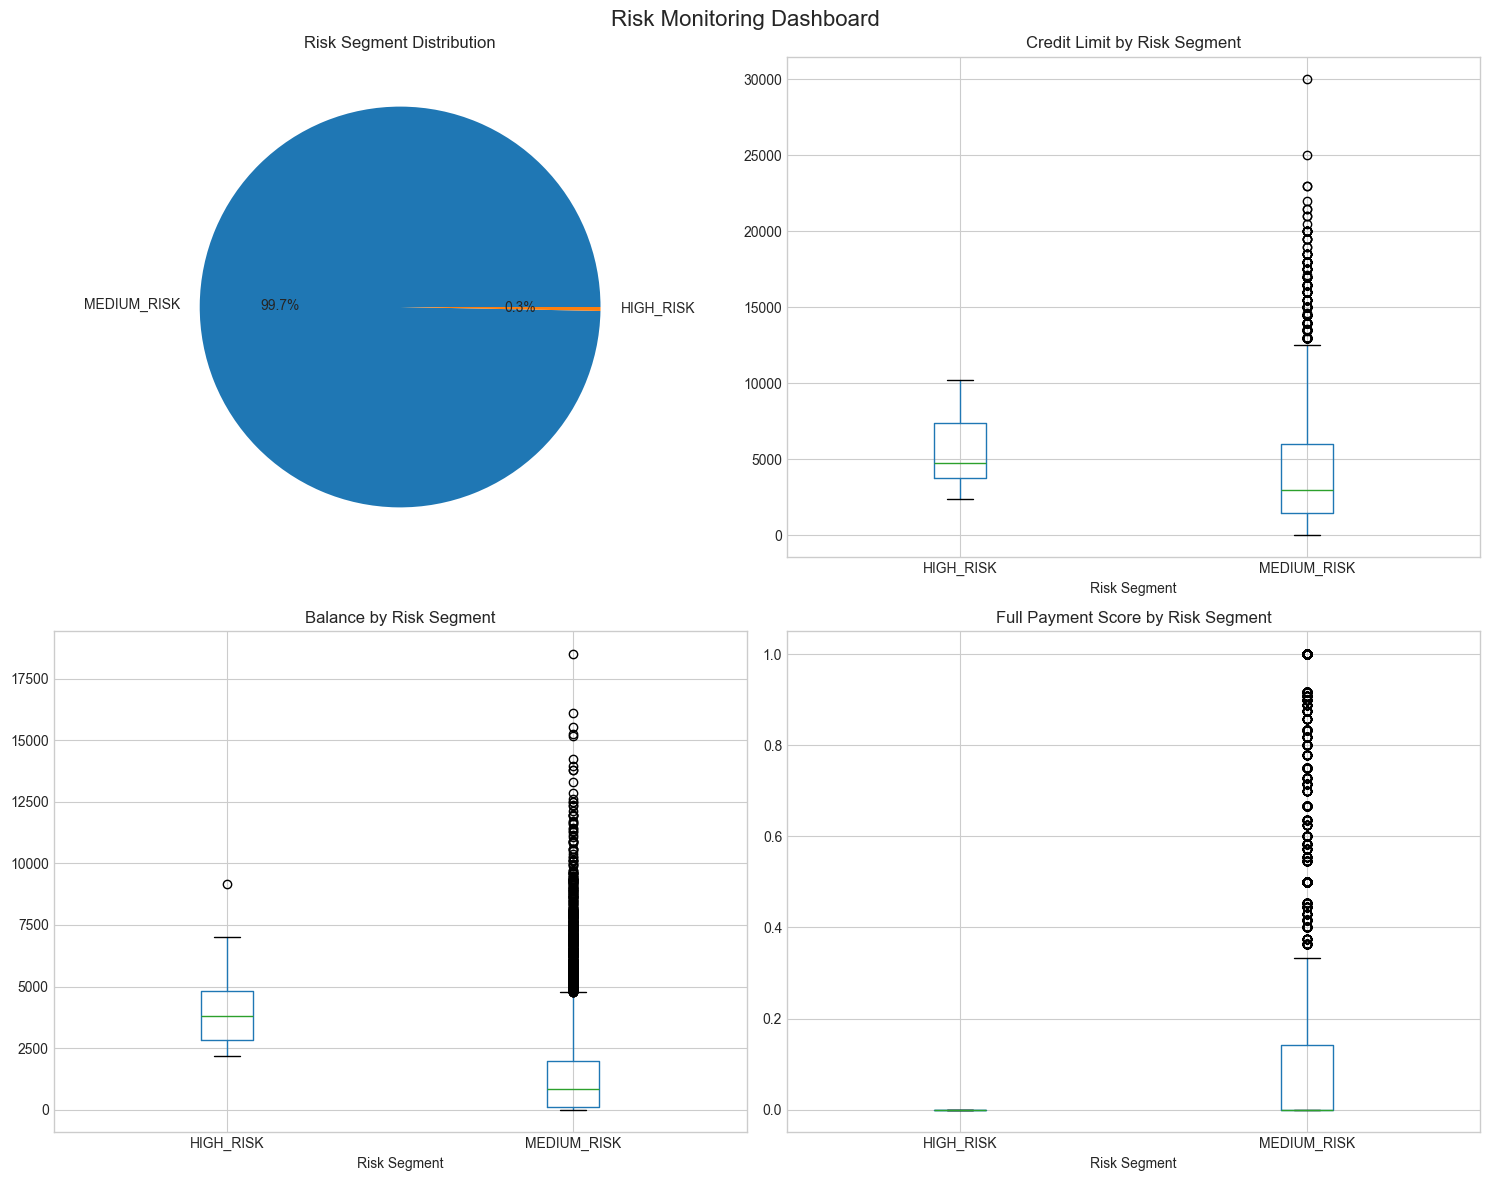

In [75]:
## Create monitoring dashboard visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Risk distribution
risk_counts = df_risk['RISK_LABEL'].value_counts()
axes[0, 0].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%')
axes[0, 0].set_title('Risk Segment Distribution')

# Risk vs Credit Limit
df_risk.boxplot(column='CREDIT_LIMIT', by='RISK_LABEL', ax=axes[0, 1])
axes[0, 1].set_title('Credit Limit by Risk Segment')
axes[0, 1].set_xlabel('Risk Segment')

# Risk vs Balance
df_risk.boxplot(column='BALANCE', by='RISK_LABEL', ax=axes[1, 0])
axes[1, 0].set_title('Balance by Risk Segment')
axes[1, 0].set_xlabel('Risk Segment')

# Risk vs Full Payment Score
df_risk.boxplot(column='PRC_FULL_PAYMENT', by='RISK_LABEL', ax=axes[1, 1])
axes[1, 1].set_title('Full Payment Score by Risk Segment')
axes[1, 1].set_xlabel('Risk Segment')

plt.suptitle('Risk Monitoring Dashboard', fontsize=16)
plt.tight_layout()
plt.show()

### Model Validation

In [76]:
# Check cluster stability
print("=== MODEL VALIDATION ===\n")

# Inertia within clusters
for risk_label in df_risk['RISK_LABEL'].unique():
    segment_data = df_risk[df_risk['RISK_LABEL'] == risk_label]
    segment_size = len(segment_data)
    avg_debt_ratio = segment_data['DEBT_TO_LIMIT_RATIO'].mean()
    avg_payment_score = segment_data['FULL_PAYMENT_SCORE'].mean()
    
    print(f"{risk_label} Segment Validation:")
    print(f"  Size: {segment_size} customers ({segment_size/len(df_risk)*100:.1f}%)")
    print(f"  Avg Debt-to-Limit: {avg_debt_ratio:.3f}")
    print(f"  Avg Payment Score: {avg_payment_score:.3f}")
    print(f"  Risk Consistency: {'High' if avg_debt_ratio > 0.5 and risk_label == 'HIGH_RISK' else 'Medium'}")
    print()

=== MODEL VALIDATION ===

MEDIUM_RISK Segment Validation:
  Size: 8832 customers (99.7%)
  Avg Debt-to-Limit: 0.386
  Avg Payment Score: 0.153
  Risk Consistency: Medium

HIGH_RISK Segment Validation:
  Size: 28 customers (0.3%)
  Avg Debt-to-Limit: 0.798
  Avg Payment Score: 0.000
  Risk Consistency: High



### A/B testing

In [77]:
# Split each risk segment for testing
test_groups = {}

for risk_label in df_risk['RISK_LABEL'].unique():
    segment_data = df_risk[df_risk['RISK_LABEL'] == risk_label].copy()
    
    # Random split
    np.random.seed(42)
    segment_data['TEST_GROUP'] = np.random.choice(['Control', 'Treatment'], size=len(segment_data))
    
    test_groups[risk_label] = {
        'control_size': len(segment_data[segment_data['TEST_GROUP'] == 'Control']),
        'treatment_size': len(segment_data[segment_data['TEST_GROUP'] == 'Treatment'])
    }

print("=== A/B TESTING FRAMEWORK ===\n")
for risk_label, groups in test_groups.items():
    print(f"{risk_label}:")
    print(f"  Control Group: {groups['control_size']} customers")
    print(f"  Treatment Group: {groups['treatment_size']} customers")
    print()

=== A/B TESTING FRAMEWORK ===

MEDIUM_RISK:
  Control Group: 4430 customers
  Treatment Group: 4402 customers

HIGH_RISK:
  Control Group: 14 customers
  Treatment Group: 14 customers

